In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d muhammadavici/animals-dataset

 92% 172M/188M [00:02<00:00, 77.9MB/s]
100% 188M/188M [00:02<00:00, 88.7MB/s]


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('animals-dataset.zip', 'r')
zip_ref.extractall('TMP')
zip_ref.close()

In [48]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen =ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
)

validation_datagen =ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
)

In [49]:
IMG_SIZE = 300

train_generator = train_datagen.flow_from_directory(
  '/content/TMP/animal dataset/train',             # Source directory
  target_size=(IMG_SIZE,IMG_SIZE),  # Resizes images
  batch_size=32,
  class_mode='categorical'        # Remember to change based the class
)
    
validation_generator = validation_datagen.flow_from_directory(
  '/content/TMP/animal dataset/val',
  target_size=(IMG_SIZE,IMG_SIZE),
  batch_size=32,
  class_mode='categorical'
)

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [67]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(50, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# Branch 1!
x1 = tf.keras.layers.Conv2D(64, (3,3), activation='elu')(x)
x1 = tf.keras.layers.MaxPooling2D(2,2)(x1)
x1 = tf.keras.layers.Conv2D(128, (3,3), activation='elu')(x1)
x1 = tf.keras.layers.MaxPooling2D(2,2)(x1)
x1 = tf.keras.layers.Dropout(0.4)(x1)
x1 = tf.keras.layers.Conv2D(128, (3,3), activation='elu')(x1)
x1 = tf.keras.layers.MaxPooling2D(2,2)(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Activation('relu')(x1)

# Rebranch from branch 1

# Branch 1-1
x1_1 = tf.keras.layers.Conv2D(64, (3,3), activation='elu')(x1)
x1_1 = tf.keras.layers.MaxPooling2D(2,2)(x1_1)
x1_1 = tf.keras.layers.BatchNormalization()(x1_1)
x1_1 = tf.keras.layers.Activation('relu')(x1_1)

# Branch 1-2
x1_2 = tf.keras.layers.Conv2D(64, (3,3), activation='elu')(x1)
x1_2 = tf.keras.layers.MaxPooling2D(2,2)(x1_2)
x1_2 = tf.keras.layers.BatchNormalization()(x1_2)
x1_2 = tf.keras.layers.Activation('relu')(x1_2)

# Total X1 branch

x1_total = tf.keras.layers.Concatenate()([x1_1,x1_2])


# Branch 2!
x2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x2 = tf.keras.layers.MaxPooling2D(2,2)(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.Activation('relu')(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D(2,2)(x2)
x2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D(2,2)(x2)
x2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D(2,2)(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.Activation('relu')(x2)
x2 = tf.keras.layers.Activation('elu')(x2)
x2 = tf.keras.layers.Activation('selu')(x2)
x2 = tf.keras.layers.Activation('tanh')(x2)
x2 = tf.keras.layers.Activation('exponential')(x2)
x2 = tf.keras.layers.Activation('relu')(x2)

# Total layer
sum_layer = tf.keras.layers.Concatenate()([x1_total,x2])


x3 = tf.keras.layers.Flatten()(sum_layer)
x3 = x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(512, activation='relu')(x3)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [68]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 298, 298, 32) 896         input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_134 (MaxPooling2D (None, 149, 149, 32) 0           conv2d_151[0][0]                 
__________________________________________________________________________________________________
dropout_33 (Dropout)            (None, 149, 149, 32) 0           max_pooling2d_134[0][0]          
____________________________________________________________________________________________

In [69]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

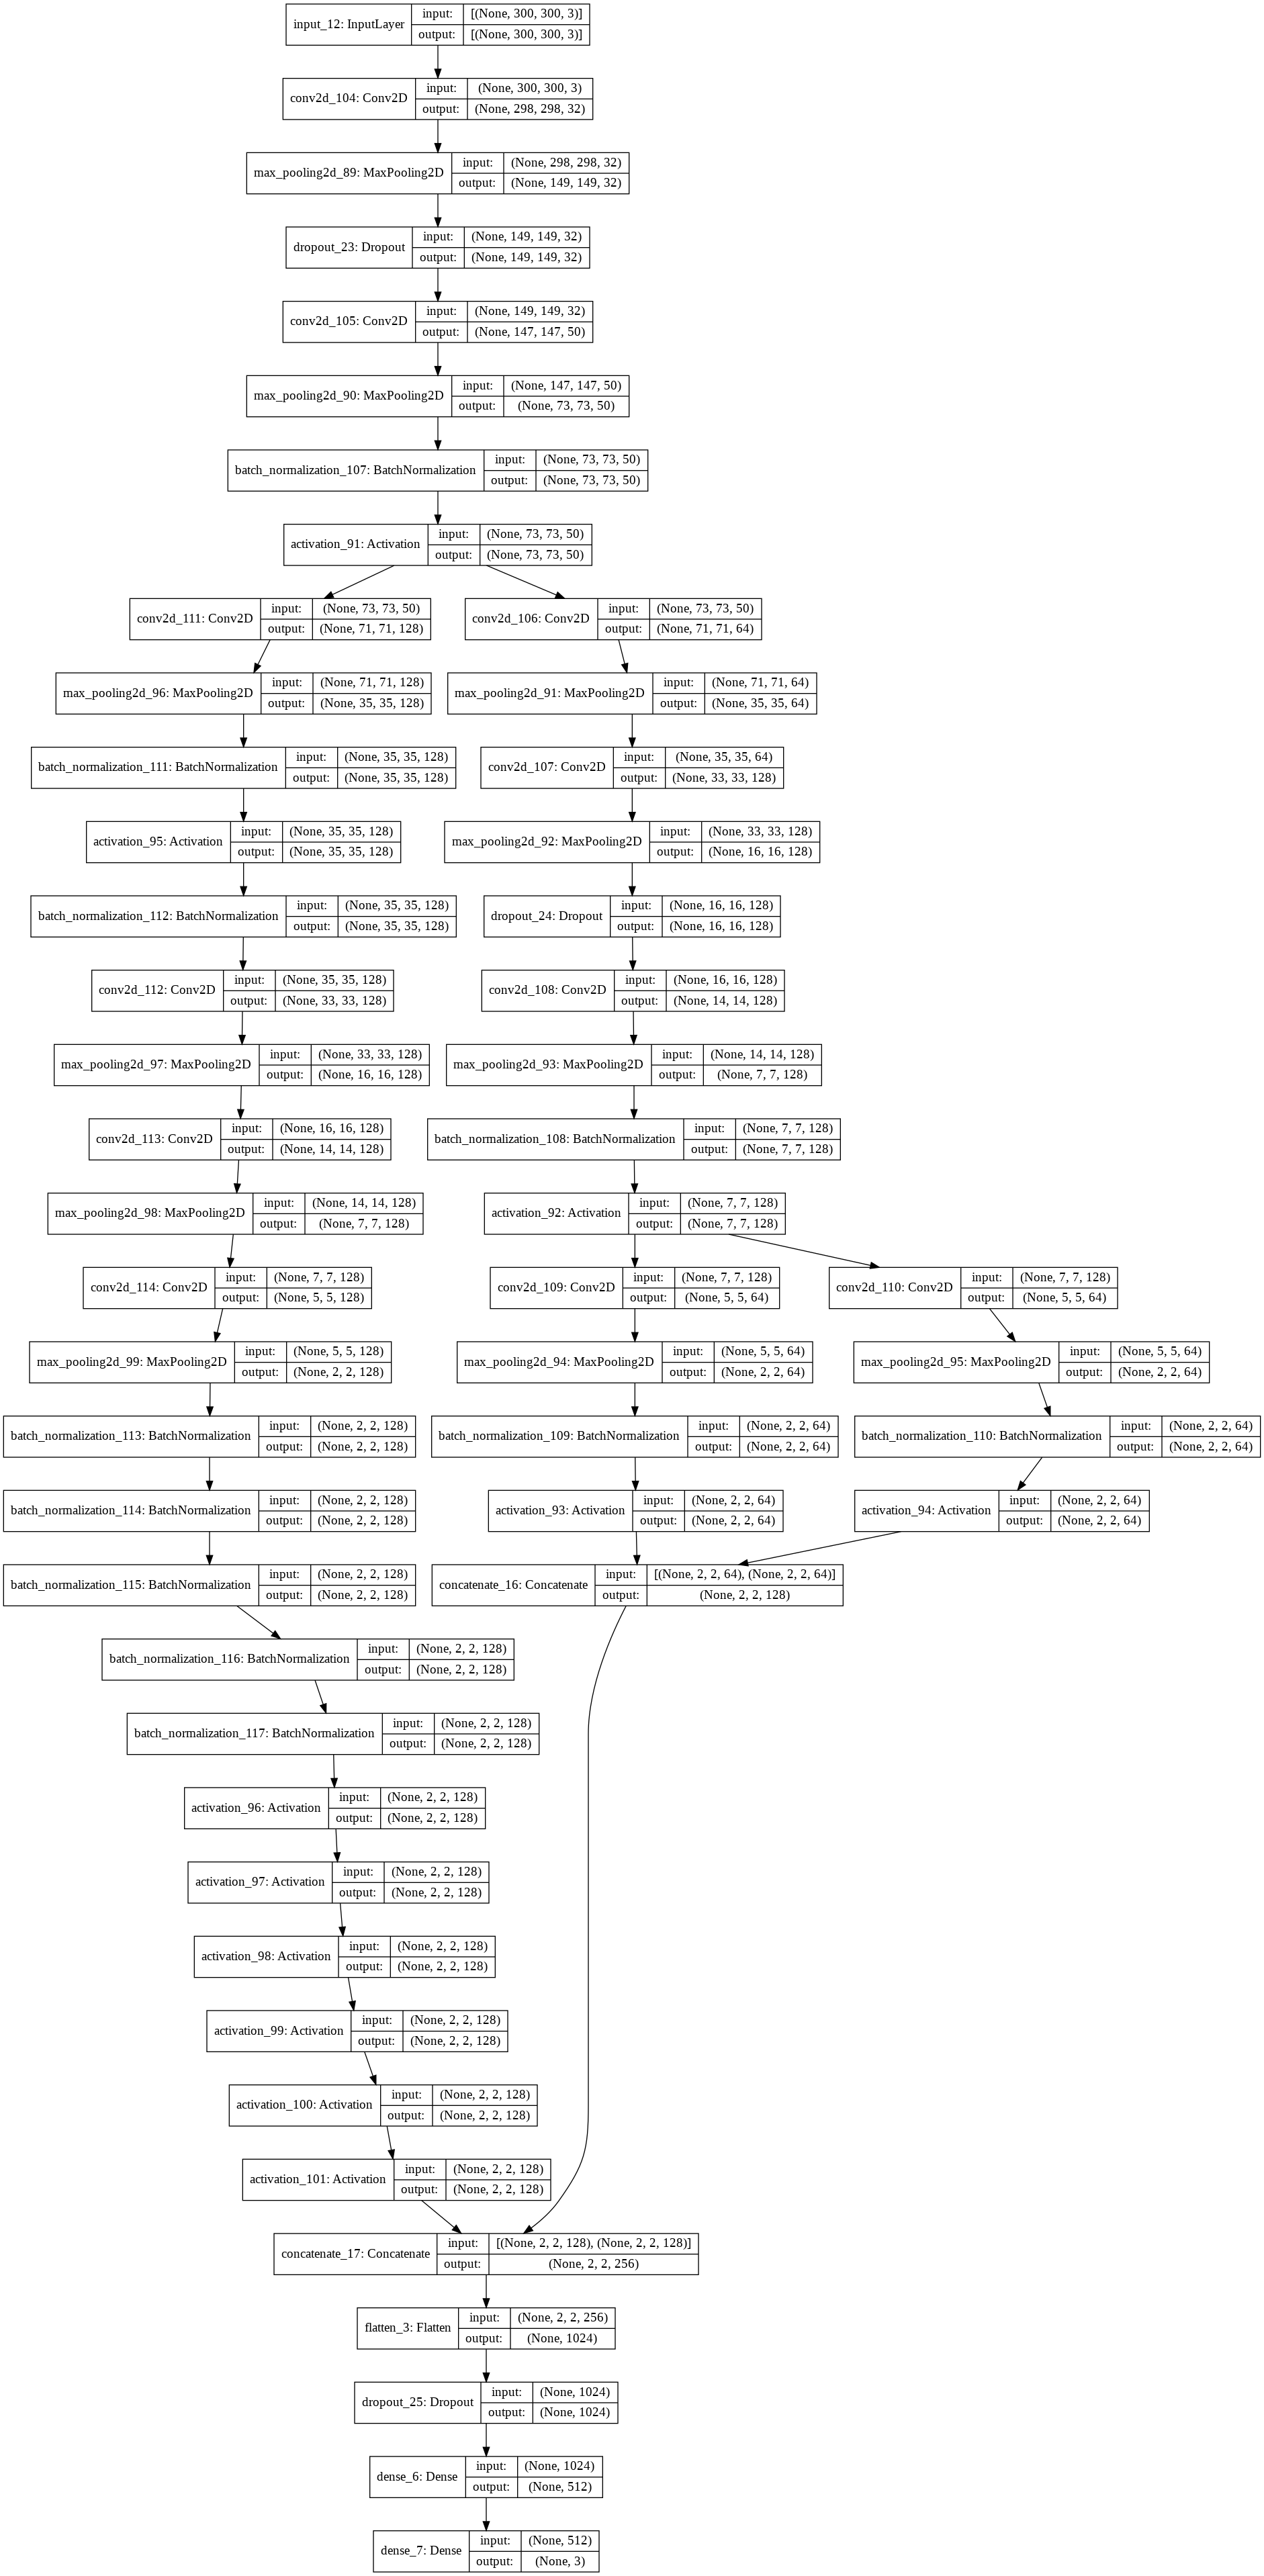

In [60]:
dot_img_file = 'example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [65]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\nAccuracy better than target training!")
      self.model.stop_training = True

callbacks = myCallback()

In [70]:
%%time
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    callbacks=[callbacks]
)

Epoch 1/10
75/75 [==============================] - 58s 755ms/step - loss: 1.7381 - accuracy: 0.4512 - val_loss: 1.1588 - val_accuracy: 0.3300
Epoch 2/10
75/75 [==============================] - 56s 743ms/step - loss: 0.8900 - accuracy: 0.5607 - val_loss: 1.2905 - val_accuracy: 0.3467
Epoch 3/10
75/75 [==============================] - 56s 743ms/step - loss: 0.8007 - accuracy: 0.5998 - val_loss: 1.5505 - val_accuracy: 0.3433
Epoch 4/10
75/75 [==============================] - 56s 745ms/step - loss: 0.7529 - accuracy: 0.6054 - val_loss: 1.9352 - val_accuracy: 0.3333
Epoch 5/10
75/75 [==============================] - 56s 744ms/step - loss: 0.7091 - accuracy: 0.6273 - val_loss: 1.4015 - val_accuracy: 0.3667
Epoch 6/10
75/75 [==============================] - 56s 746ms/step - loss: 0.7190 - accuracy: 0.6213 - val_loss: 1.1844 - val_accuracy: 0.3867
Epoch 7/10
75/75 [==============================] - 56s 746ms/step - loss: 0.6892 - accuracy: 0.6501 - val_loss: 1.4676 - val_accuracy: 0.3433

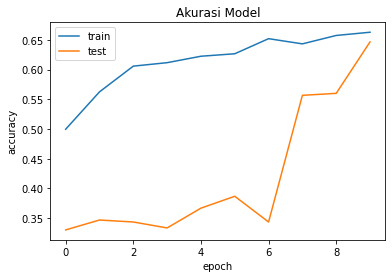

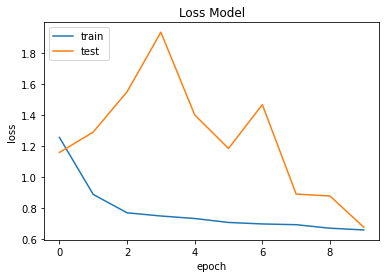

In [71]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = tf.keras.layers.Conv2D(32, (5,5), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(50, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

x3 = tf.keras.layers.Flatten()(x)
x3 = x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(512, activation='relu')(x3)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

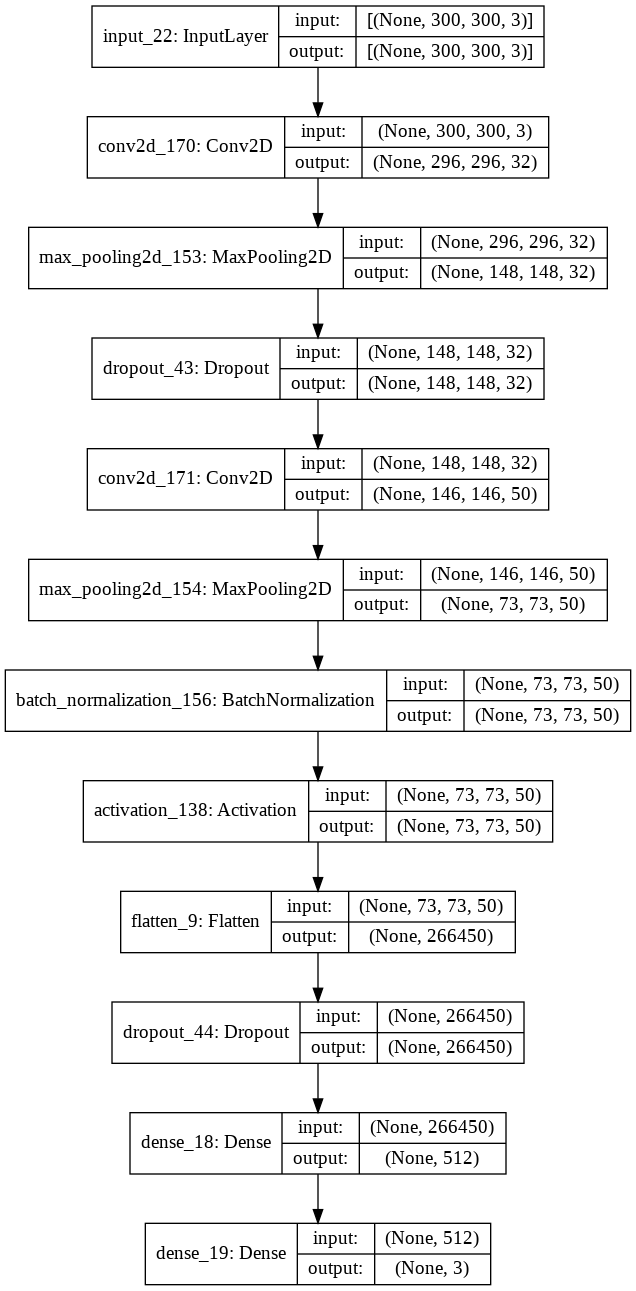

In [81]:
dot_img_file = 'example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)